# Machine Learning 1 - KIT

In this exercise you will classify images taken from google's reCAPTCHA.
<div>
<img src=https://i.ds.at/LuvqbQ/rs:fill:1600:0/plain/2022/06/23/captcha.jpg width="300">
<div>

reCAPTCHA was created to differentiate between real humans and computer porgrams. With the breakthrough of deep learning based methods, these tactics to differentiate between humans and machines no longer work. Computer programs nowadays are perfectly able to solve classic captchas.

This notebook shows the initial steps to load the datasets, create a dummy classifier and use the classifier to create the resulting file, which you will upload for grading.

## Your Task



*   Split the labeled Data into sensible training and validation datasets
*   Train a model to classify the training data
*   Evaluate the model on your validation data
*   If you think your model has a high accuracy, and is generalized well, predict the classes of the images from the testdataset and upload the results.csv at https://kit-ml1.streamlitapp.com/
* You will get Bonus Points in the exam if your accuracy on test-data is high enough

## Learning Goals

* How to preprocess data
* How to split data to prevent over- and underfitting
* How to train a model
* How to improve accuracy on unlabeled data
    * Model architecture
    * Model initialization
    * Optimizer
    * Batch size
    * Image Augmentation
    * ...



In [1]:
## Lots of imports
import matplotlib.pyplot as plt # for visualization
import numpy as np #for fast calculation of matrices and vectors
import os # for reading and writing files
import pandas as pd # for creating dataframes and later saving the .csv
import torch # PyTorch
import torch.nn as nn # layers of neural netowrk
from torch.utils.data import random_split, DataLoader # Creating datasets
import torchvision # the part of PyTorch which is used for images
from torchvision import datasets, models, transforms # used for loading images


torch.manual_seed(3407) # makes your code deterministic so you can compare your results
np.random.seed(3407)

c:\Python38\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Download the two .zip files that are available on ilias.
You should have `train_val.zip` and `test.zip`




## Using Google Colab but no Google Drive

Upload both files, unzip them. This method has the disadvantage that you have to do it every time you reload the Colab


In [ ]:
from google.colab import files
uploaded = files.upload()

!unzip test.zip
!unzip train_val.zip
# Where is the folder test_data and train_val_data. ./ says it is in the same folder as this jupyter notebook
root = "./"


## Using Google Colab and Google Drive


* Upload both files (drag and drop) to your free google drive account https://drive.google.com/drive/my-drive
* On the left press the folder (Dateien) Symbol.
* Then press the *Mount drive/ Drive bereitstellen* button which has the google drive symbol (triangle)
* Allow access to your google drive


In [ ]:
## If you did this correctly you should see here "drive" and "sample_data"
from google.colab import drive
drive.mount('/content/drive')
!ls


Unzip the files in your Google Drive

In [ ]:
!unzip drive/MyDrive/train_val.zip -d drive/MyDrive/
!unzip drive/MyDrive/test.zip -d drive/MyDrive/

This should have created the folders train_val_data and test_data in your google drive.

In [ ]:
root = "./drive/MyDrive/" # where are these folders located?

## Using local Jupyter

* Download both .zip files from Ilias
* Extract them
* Put this notebook .ipynb in the folder that also contains the folders `test_data` and `train_val_data`

In [2]:
# Where is the folder test_data and train_val_data. ./ says it is in the same folder as this jupyter notebook
root = "./"

Now we have to create Datasets from these folders.

For the train_val folder the images are sorted into their correct class folder.
For the test folder we don't know the correct classes.

We will use ImageFolder Datasets from  [PyTorch](https://pytorch.org/vision/stable/generated/torchvision.datasets.ImageFolder.html#torchvision.datasets.ImageFolder)

Each Image Folder uses [transforms](https://pytorch.org/vision/stable/transforms.html) to augment the image and create a tensor out of it.

Some initial transforms are given. You are allowed (and probably should) add more transformations or modify the existing ones

In [3]:
test_transform = transforms.Compose([
        transforms.CenterCrop(120), # makes that every image has size 120*120 # you can choose different resolutions
        # you can add more augmentations here
        transforms.ToTensor(), # creates a tensor out of Image
    ])

train_val_transform = transforms.Compose([
        transforms.CenterCrop(120), # should be the same resolution as the test_transform
        transforms.ToTensor(),
    ])

Now we use these transformations to create our dataset

In [4]:
train_val_folder = root + "train_val_data/"
train_val_dataset = datasets.ImageFolder(train_val_folder, transform=train_val_transform)

train_val_length = len(train_val_dataset)
print(f"The trainval dataset contains {train_val_length} labeled images") # should be 3000


test_folder = root + "test_data/"
test_dataset = datasets.ImageFolder(test_folder, transform=test_transform)

print(f"The test dataset contains {len(test_dataset)} unlabeled images") # should be 8730

The trainval dataset contains 3000 labeled images
The test dataset contains 8730 unlabeled images


Let's look at the first element of our dataset

An element of a dataset contains 2 fields. (should be 2). The first field is an image, the second value is its corresponding label 

tensor of first image tensor([[[0.3490, 0.3176, 0.1804,  ..., 0.1020, 0.1294, 0.1255],
         [0.2118, 0.1569, 0.0980,  ..., 0.1333, 0.1725, 0.1961],
         [0.1490, 0.1098, 0.1137,  ..., 0.2039, 0.2157, 0.2471],
         ...,
         [0.6314, 0.6314, 0.6196,  ..., 0.4902, 0.4863, 0.4588],
         [0.6392, 0.6510, 0.6314,  ..., 0.4706, 0.4706, 0.4353],
         [0.6431, 0.6039, 0.5608,  ..., 0.4392, 0.4431, 0.4157]],

        [[0.3373, 0.3098, 0.1804,  ..., 0.1608, 0.1961, 0.2039],
         [0.2118, 0.1686, 0.1216,  ..., 0.1804, 0.2196, 0.2431],
         [0.1569, 0.1373, 0.1529,  ..., 0.1804, 0.1882, 0.2157],
         ...,
         [0.6510, 0.6392, 0.6157,  ..., 0.4196, 0.4235, 0.4000],
         [0.6549, 0.6627, 0.6392,  ..., 0.4392, 0.4588, 0.4314],
         [0.6588, 0.6235, 0.5843,  ..., 0.4706, 0.5098, 0.4980]],

        [[0.3412, 0.3059, 0.1725,

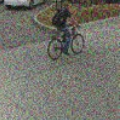

We have the follwing classes ['Bicycle', 'Bridge', 'Bus', 'Car', 'Chimney', 'Crosswalk', 'Hydrant', 'Motorcycle', 'Other', 'Palm', 'Stair', 'Traffic Light']
Each class gets an index value {'Bicycle': 0, 'Bridge': 1, 'Bus': 2, 'Car': 3, 'Chimney': 4, 'Crosswalk': 5, 'Hydrant': 6, 'Motorcycle': 7, 'Other': 8, 'Palm': 9, 'Stair': 10, 'Traffic Light': 11}
For the first image we have index 0


In [5]:
first_elem = train_val_dataset.__getitem__(0)
print(f"An element of a dataset contains {len(first_elem)} fields. (should be 2). The first field is an image, the second value is its corresponding label \n")

# the first index should be a tensor representation of an image
print("tensor of first image", first_elem[0], "\n")

print("image should be of shape 3,size,size: ", first_elem[0].shape)

# convert tensor back to a PIL image and visualize it with display()
display(transforms.ToPILImage()(first_elem[0]))
# Each folder is a class
classes = train_val_dataset.classes
print("We have the follwing classes", classes)

# Each classname is assigned an index
class_names = train_val_dataset.class_to_idx
print("Each class gets an index value", class_names)

# the second index is the numerical value of our label taken from the folder name
print(f"For the first image we have index {first_elem[1]}")

Split this dataset into a training set and a validation set.
For this you can use [random_split](https://pytorch.org/docs/stable/data.html#torch.utils.data.random_split)

In this example we will use 10% of the dataset for training and 90% for validation. You should change this percentage to a reasonable value
Remember overfitting and underfitting

In [6]:
train_percentage = 0.1 # how much of the dataset should be used for training --> change this value

no_train_images = int(train_val_length * train_percentage)
no_valid_images = train_val_length - no_train_images

train_dataset, valid_dataset = random_split(dataset=train_val_dataset, lengths=[no_train_images ,no_valid_images], generator=torch.Generator().manual_seed(42))

print(f"we divided the {len(train_val_dataset)} labeled images into {len(train_dataset)} training images and {len(valid_dataset)} validation images")

we divided the 3000 labeled images into 300 training images and 2700 validation images


Let's Create [Dataloaders](https://pytorch.org/docs/stable/data.html)
Dataloaders loads our data in batches and faster so out training speed increases.

The important arguments of the Dataloader are `dataset, batch_size, shuffle and  num_workers`
We are already giving the argument for dataset, you should choose fitting values for the other arguments

Let's create dataloaders for train and test

In [7]:
train_loader = DataLoader(dataset=train_dataset) # You are free to add values for other arguments
valid_loader = DataLoader(dataset=valid_dataset) # You are free to add values add values for other arguments

Lets visualize images from the train loader

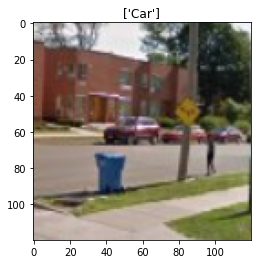

In [8]:
def vis_batch(loader):
    def show(inp, label):
        fig = plt.gcf()
        plt.imshow(inp.permute(1,2,0))
        plt.title(label)
    
    for batch_inputs, labels in loader:
        grid = torchvision.utils.make_grid(batch_inputs)
        show(grid, label=[classes[int(labels[x])] for x in range(len(labels))])
        break
vis_batch(train_loader)

Let's create a  dummy pytorch model that takes an image and predicts a class

In [33]:
# Do not use this model.
model = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3,padding=1),
    nn.Flatten(),
    nn.Linear(in_features=120*120*3, out_features=12) # your model has to predict 12 classes so your last layer should most likely be a linear layer with 12 out_features
)

In [63]:
import json
from roboflow import Roboflow

rf = Roboflow(api_key="BIKS7o3Tft2jWLacKNP8")
project = rf.workspace().project("ml-ubung-captcha")
model = project.version(2).model

# Read the image file and make the prediction
image_path = r"C:\Users\Vito Völker\Desktop\GitHub\CAPTCHA_Challenge\test_data\test\03000.png"
prediction = model.predict(image_path)

# Convert the prediction to a JSON string
prediction_json = json.dumps(prediction.json())

# Convert the JSON string to a Pandas DataFrame
df = pd.read_json(prediction_json)

print(df)

# Save the DataFrame to a CSV file
df.to_csv(r"C:\Users\Vito Völker\Desktop\GitHub\CAPTCHA_Challenge\test.csv", index=False)


loading Roboflow workspace...
loading Roboflow project...
                                         predictions
0  {'top': 'Car', 'confidence': 0.933, 'predictio...


You should use a different model. 
Also you should now train your model. 

In [1]:
import json
import os
import pandas as pd
from roboflow import Roboflow

# Initialize the Roboflow client
rf = Roboflow(api_key="BIKS7o3Tft2jWLacKNP8")

# Get the project and model
project = rf.workspace().project("ml-ubung-captcha")
model = project.version(2).model

# Set the directory containing the images
image_dir = r"C:\Users\Vito Völker\Desktop\GitHub\CAPTCHA_Challenge\test_data\test"

# Get the list of image file names
image_names = os.listdir(image_dir)

# Create a list of dictionaries to store the predictions
data = []
i=0
# Loop through the images
for image_name in image_names:
    
    # Read the image file and make the prediction
    image_path = os.path.join(image_dir, image_name)
    prediction = model.predict(image_path)

    # Convert the prediction to a dictionary
    prediction_dict = prediction.json()

    # Extract the relevant information from the dictionary
    predictions = prediction_dict['predictions'][0]['predictions']
    
    # Create a dictionary with the class names as keys and the confidence scores as values
    scores = {prediction['class']: prediction['confidence'] for prediction in predictions}

    # Add the image name and scores to the list of dictionaries
    data.append({'ImageName': image_name, **scores})
    i = i+1
    print(i)

# Create a DataFrame from the list of dictionaries
df = pd.DataFrame(data)

# Save the DataFrame to a CSV file
df.to_csv(r"C:\Users\Vito Völker\Desktop\GitHub\CAPTCHA_Challenge\result.csv", index=False)

loading Roboflow workspace...
loading Roboflow project...
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
26

In [ ]:
## Train your model here:




The following method should not be changed. It predicts the classes for each image in the test dataset and stores them in a .csv file.


In [ ]:
def create_result_file(model, test_dataset, classes): # DO NOT CHANGE THIS METHOD
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    keys = ["ImageName", *classes]  

    prediction_dict = {key: [] for key in keys}
    names = test_dataset.imgs
    model.to(device)
    model.eval() # set model to evaluation mode. 
    for i in range(len(test_dataset)):
        input = test_dataset.__getitem__(i)
        input = input[0].to(device).unsqueeze(0) # take image tensor and add batch dimension
        with torch.no_grad(): # don't calculate gradients
            outputs = model(input).cpu().squeeze().numpy() # get prediction for input image
            prediction_dict["ImageName"].append(os.path.basename(names[i][0])) # save image name
            for class_idx, class_name in enumerate(classes): # save prediction for each class 
                prediction_dict[class_name].append(outputs[class_idx])
        
    df = pd.DataFrame.from_dict(prediction_dict) # convert list into pandas dataframe
    df.to_csv("result.csv", index=False) # save dataframe as .csv

After training we can execute the 
`
create_result_file(model, test_dataset, classes) method
`
In this given code we skip training and use our untrained model


In [36]:
create_result_file(model, test_dataset, classes)

If you use Google colab, press the button `update/aktualisieren`
<div>
<img src=https://git.scc.kit.edu/vy9905/ml2images/-/raw/main/UpdateColab.jpg width="300">
<div>
You should see that the file result.csv was created. You can now download this file and upload it at

https://kit-ml1.streamlitapp.com/
